In [6]:
from Models.model_sources.markov_source import MarkovChain
from Models.MMC import MMC
from Models.HMC import HMC
from Models.DBN import FMC
from Models.model_sources.mtd_source import MTD

from Datasets import Blocksworld_Data, Markov_Data_Casual

from Datasets.Markov_Data import HMM_Data
from Datasets.MMC_Data import MMC_data
from Datasets.Markov_Data_Large import HMM_Decisive
from Datasets.Fruit_Data import fruit_domain
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

import warnings

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import pandas as pd
import numpy as np
import seaborn as sns

from mtdlearn.mtd import MTD, RandomWalk
from mtdlearn.preprocessing import PathEncoder, SequenceCutter

In [19]:
import requests
import pandas as pd

def get_crypto_price(symbol, exchange, start_date = None):
    api_key = 'QEUZDNSCRV22B7VL'
    api_url = f'https://www.alphavantage.co/query?function=CRYPTO_INTRADAY&symbol={symbol}&market={exchange}&apikey={api_key}&interval=30min&outputsize=full&page=1'
    raw_df = requests.get(api_url).json()
    #print(raw_df['Time Series Crypto (30min)'])
    df = pd.DataFrame(raw_df['Time Series Crypto (30min)']).T
    #df = df.rename(columns = {'1a. open (USD)': 'open', '2a. high (USD)': 'high', '3a. low (USD)': 'low', '4a. close (USD)': 'close', '5. volume': 'volume'})
    for i in df.columns:
        df[i] = df[i].astype(float)
    df.index = pd.to_datetime(df.index)
    #df = df.iloc[::-1].drop(['1b. open (USD)', '2b. high (USD)', '3b. low (USD)', '4b. close (USD)', '6. market cap (USD)'], axis = 1)
    if start_date:
        df = df[df.index >= start_date]
    return df

df = get_crypto_price(symbol = 'BTC', exchange = 'USD')
df['Change'] = df['4. close'].diff()

df['Change_enc'] = np.nan

df.loc[df.Change < 0.0, 'Change_enc'] = '1_DROP'
#df.loc[df.Change < -40, 'Change_enc'] = '0_HUGE_DROP'

df.loc[df.Change > 0.0, 'Change_enc'] = '2_RISE'
#df.loc[df.Change > 40, 'Change_enc'] = 'HUGE_RISE'

#df.loc[df.Change.between(-5, 5), 'Change_enc'] = 'NO_CHANGE'

df.dropna(inplace=True)


In [8]:
import requests
import pandas as pd

interval = "1h"
symbol = "ETH-USD"
def get_crypto_price(symbol, exchange,interval, start_date = None):
    api_key = 'QEUZDNSCRV22B7VL'
    api_url = f'https://eodhistoricaldata.com/api/intraday/{symbol}.CC?api_token=630d712fd8bd74.01254339&interval={interval}&fmt=json'
    #print(requests.get(api_url).text)
    raw_df = requests.get(api_url).json()
    df = pd.DataFrame(raw_df)
    #df = df.rename(columns = {'1a. open (USD)': 'open', '2a. high (USD)': 'high', '3a. low (USD)': 'low', '4a. close (USD)': 'close', '5. volume': 'volume'})
    df['close'] = df['close'].astype(float)
    #df.index = pd.to_datetime(df.index)
    #df = df.iloc[::-1].drop(['1b. open (USD)', '2b. high (USD)', '3b. low (USD)', '4b. close (USD)', '6. market cap (USD)'], axis = 1)
    return df

df = get_crypto_price(symbol = symbol, exchange = 'USD', interval = interval)
df['Change'] = df['close'].diff()

df['Change_enc'] = np.nan
std = df.std()['Change']

df.loc[df.Change < 0.0, 'Change_enc'] = 'drop'
df.loc[df.Change <= -std, 'Change_enc'] = 'big_drop'
df.loc[df.Change <= -2*std, 'Change_enc'] = 'bigger_drop'
df.loc[df.Change <= -3*std, 'Change_enc'] = 'biggest_drop'

df.loc[df.Change > 0.0, 'Change_enc'] = 'rise'
df.loc[df.Change >= std, 'Change_enc'] = 'big_rise'
df.loc[df.Change >= 2*std, 'Change_enc'] = 'bigger_rise'
df.loc[df.Change >= 3*std, 'Change_enc'] = 'biggest_rise'

# New York
# London
# Asia

#df.loc[df.Change.between(-5, 5), 'Change_enc'] = 'NO_CHANGE'

df.dropna(inplace=True)

/tmp/ipykernel_13590/2238809728.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  std = df.std()['Change']


In [ ]:
df

df = pd.read_csv("/mnt/watchandhelp/PycharmProjects/mtd-learn/examples/euro_usd.csv")

df['Change'] = df.Closing_rate.diff()

df['Change_enc'] = np.nan

df.loc[df.Change < 0.0, 'Change_enc'] = '1_DROP'
df.loc[df.Change < -0.005, 'Change_enc'] = '0_BIG_DROP'
df.loc[df.Change >= 0, 'Change_enc'] = '2_RISE'
df.loc[df.Change >= 0.005, 'Change_enc'] = '3_BIG_RISE'

df.dropna(inplace=True)

## Fit models

In [9]:
aics = []
bics = []

In [10]:
from sklearn.model_selection import train_test_split

order = 3

sc = SequenceCutter(order)
x, y = sc.transform(df.Change_enc.values)

pe = PathEncoder(order)
pe.fit(x, y)

x_tr, y_tr = pe.transform(x, y)


In [11]:
pe.label_dict_inverse

{0: 'big_drop',
 1: 'big_rise',
 2: 'bigger_drop',
 3: 'bigger_rise',
 4: 'biggest_drop',
 5: 'biggest_rise',
 6: 'drop',
 7: 'rise',
 8: 'null'}

In [12]:

div = round(len(x_tr)*.85)
#(X_train, X_test, y_train, y_test) = train_test_split(x_tr, y_tr)
X_train, X_test, y_train, y_test = x_tr[div:, :],x_tr[:div, :], y_tr[div:], y_tr[:div]
#X_train, y_train = x_tr, y_tr
#X_test, y_test = x_tr, y_tr
amount_to_average = 1

sgo_type = "greedy"
methods = [HMC, MMC, FMC, MTD] #FMC]
types = [m.__name__ for m in methods]

state_count = len(np.unique(x_tr))
for _ in range(amount_to_average):

    args_training = {"X_train": X_train, "y_train": y_train}
    args_testing =   {"X_test": X_test, "y_test": y_test}
    results_training = []
    results_testing = []

    for m in methods:
        model = m(state_count, order=order)
        training = MarkovChain.calculate_time(model.train, args_training)
        testing = MarkovChain.calculate_time(model.test, args_testing)
        #results_training.append(training[0])
        results_testing.append(testing[0])

        pred_res = model.predict(X_test)
        count = 0
        for i,p in enumerate(pred_res):
            if "drop" in pe.label_dict_inverse[p] and "drop" in pe.label_dict_inverse[y_test[i]]:
                count += 1
            elif "rise" in pe.label_dict_inverse[p] and "rise" in pe.label_dict_inverse[y_test[i]]:
                count += 1
        print(count/len(pred_res))


        #print(count/sum)

        print(model.__class__.__name__)
        print(f"Training: {training}")
        print(f"Testing: {testing}")
        print("")

    print(results_testing)

0.4979253112033195
HMC
Training: (None, 0.010726)
Testing: (0.2713692946058091, 0.147954)

0.5477178423236515
MMC
Training: (None, 0.00505)
Testing: (0.3825726141078838, 0.065981)

0.5145228215767634
FMC
Training: (None, 0.00645)
Testing: (0.35269709543568467, 0.203142)

0.5170124481327801
MTD
Training: (None, 0.920971)
Testing: (0.37012448132780085, 0.000267)

[0.2713692946058091, 0.3825726141078838, 0.35269709543568467, 0.37012448132780085]


In [82]:
results_testing

[0.3897035282064417,
 0.4329896907216495,
 0.41403598642504963,
 0.41384388807069217]

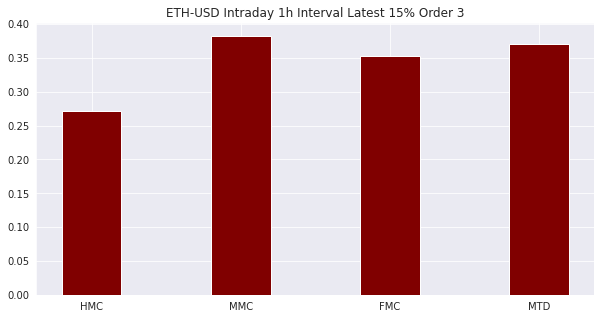

In [13]:

def create_bar_graph(data, title, types):
    plt.figure(figsize=(10, 5))

    # creating the bar plot
    plt.bar(types, data, color='maroon',
            width=0.4)

    plt.title(title)
    plt.show()

create_bar_graph(results_testing, f"{symbol} Intraday {interval} Interval Latest 15% Order {order}", [m.__name__ for m in methods])

In [16]:
[m.__name__ for m in methods]

['HMC', 'MMC', 'FMC', 'MTD']

## Choose model

In [22]:
xs = [0, 1, 2, 3, 4]

In [18]:
sns.lineplot(x=xs, y=aics)
sns.lineplot(x=xs, y=bics);

ValueError: All arrays must be of the same length